In [1]:
import numpy as np
import matplotlib.pylab as plt

import pymc as pm
import arviz as az
import aesara.tensor as at

import astropy.cosmology as cosmo
import astropy.units as u
import seaborn as sns
import scipy.integrate as si

from src.cosmology import FlatLCDM, Flatw0CDM, FlatCPLCDM
from src.utils import interp, md_sfr, trapz

# Mock Data

## Redshift
$$
z \sim \text{MD 2014}
$$

$$
\sigma_z = 0.1*(1+z) 
$$

In [2]:
Nobs = 1000

Text(0.5, 9.444444444444438, '$z$')

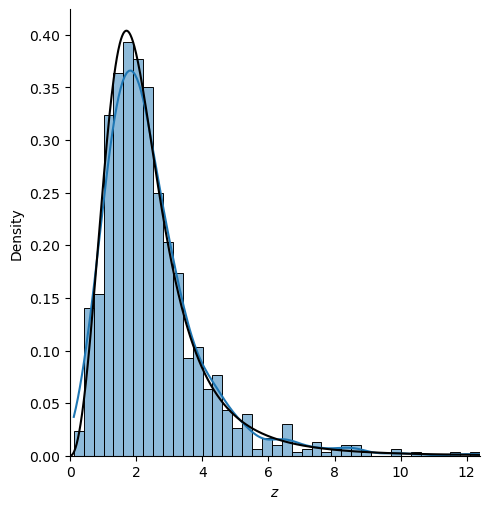

In [3]:
np.random.seed(1)

zi = np.expm1(np.linspace(np.log(1), np.log(1+100), 1024))
pz = (1+zi)**1.7/(1+((1+zi)/(1+1.9))**5.6)*cosmo.Planck18.differential_comoving_volume(zi).to(u.pc**3/u.sr)
cz = si.cumulative_trapezoid(pz, zi, initial=0)
zt = np.interp(np.random.uniform(low=0, high=cz[-1], size=Nobs), cz, zi)

sns.displot(zt, kde=True, stat='density')
plt.plot(zi, pz/cz[-1], color='k')
plt.axis(xmin=0, xmax=max(zt))
plt.xlabel(r'$z$')

In [4]:
np.random.seed(1)

sigma_z = 0.1*(1+zt)
zo = zt+sigma_z*np.random.randn(Nobs)

## $\Lambda$CDM Injection

$$
\frac{\sigma_{DL}}{DL} = 0.3*\Big(0.1+\frac{DL}{DL(z=10)}\Big)
$$

In [5]:
np.random.seed(1)

cp = cosmo.Planck18
DLt = cp.luminosity_distance(zt).to(u.Gpc).value #gpc

DL10 = cp.luminosity_distance(10).to(u.Gpc).value
sigma_DL = 0.3*DLt*(0.1+DLt/DL10)
do = DLt+sigma_DL*np.random.randn(Nobs)

In [6]:
print(np.where(zo<0), np.where(do<0)) # check whether zo<0, do<0.

(array([], dtype=int64),) (array([], dtype=int64),)


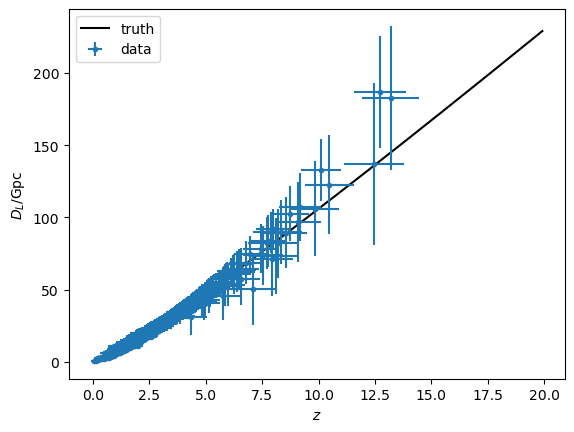

In [7]:
m = zi < 20
plt.plot(zi[m], cp.luminosity_distance(zi).to(u.Gpc).value[m], color='k', label='truth')
plt.errorbar(zo, do, xerr=sigma_z, yerr=sigma_DL, fmt='.', label='data')
plt.xlabel(r'$z$')
plt.ylabel(r'$D_L / \mathrm{Gpc}$')
plt.legend()

# Estimation

$\vec{\Omega}_C=\text{Cosmo Params}$

$$
P(\vec{\Omega}_C|\vec{D}) \propto P(\vec{\Omega}_C) \int_{D_L, z} dD_L . dz . P(\vec{D}|D_L, z) . P(z) . P(D_L|z, \vec{\Omega}_C)
$$

## $\Lambda$CDM Recovery

In [8]:
def make_model(zo, do, sigma_z, sigma_DL, zmax=50, Nz=1024):
    zinterp = np.expm1(np.linspace(np.log(1), np.log1p(zmax), Nz))
    
    with pm.Model() as model:
        h = pm.Uniform('h', 0.2, 1.5, initval=cp.H(0).value/100)
        Om = pm.Uniform('Om', 0.0, 1.0, initval=cp.Om0)
        
        dH = 2.99792 / h #Gpc
        
        cos = FlatLCDM(Om)
        dLinterp = dH*cos.dLs(zinterp)
        dVCinterp = dH*dH*dH*dH*dH*cos.dVdz(zinterp)
        
        zden = md_sfr(zinterp, 2.7, 1.9, 5.6)*dVCinterp/(1+zinterp)
        norm = trapz(zden, zinterp)
        log_norm = at.log(norm)
        
        z = pm.Uniform('z', 0, zmax, initval=zo, shape=zo.shape[0])
        var = at.sum(at.log(interp(z, zinterp, zden))-log_norm)
        pm.Potential('zprior', at.sum(at.log(interp(z, zinterp, zden)) - log_norm))
        dL = pm.Deterministic('dL', interp(z, zinterp, dLinterp))

        pm.Normal('z_likelihood', mu=z, sigma=sigma_z, observed=zo)
        pm.Normal('dL_likelihood', mu=dL, sigma=sigma_DL, observed=do)
    
    return model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [h, Om, z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 171 seconds.
The acceptance probability does not match the target. It is 0.8814, but should be close to 0.8. Try to increase the number of tuning steps.


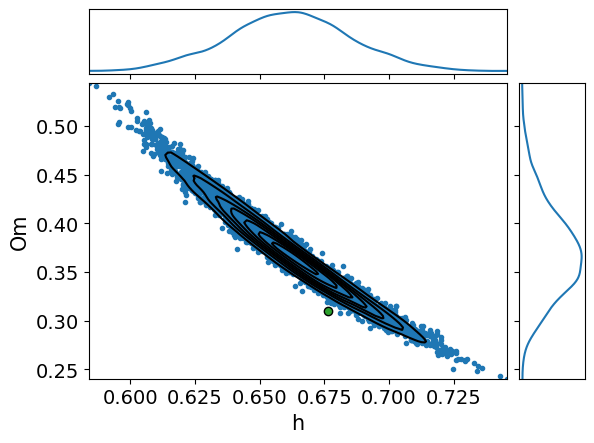

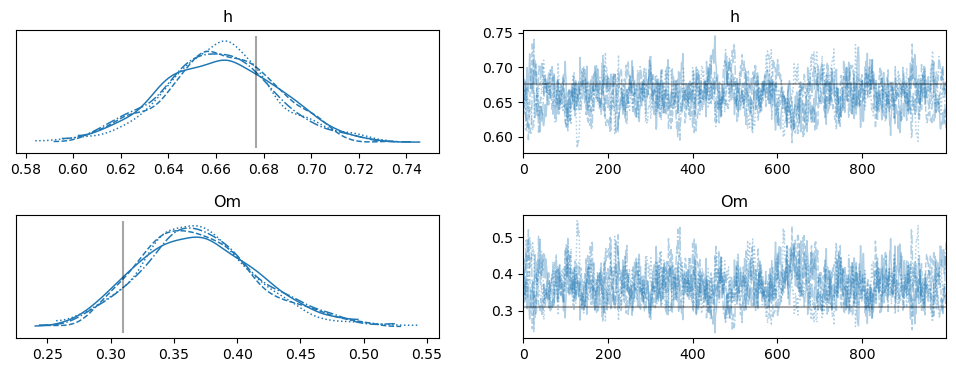

In [9]:
with make_model(zo, do, sigma_z, sigma_DL) as model:
    trace = pm.sample()
    
    axes = az.plot_pair(trace, var_names=['h', 'Om'], marginals=True, kind=['scatter', 'kde'], divergences=True, 
             reference_values={'h': cp.H0/100, 'Om': cp.Om0})
    fig = axes.ravel()[0].figure
    fig.savefig('/home/soumendrakishore.roy/cosmo_gw_systematics/Results/in_LCDM_es_LCDM_corner.png')
    
    axes1 = az.plot_trace(trace, compact=True, var_names=['h', 'Om'],
                  lines=[('h', {}, cp.H0/100),
                         ('Om', {}, cp.Om0)])
    axes1.ravel()[0].figure.subplots_adjust(hspace=0.5)
    fig1 = axes1.ravel()[0].figure 
    fig1.savefig('/home/soumendrakishore.roy/cosmo_gw_systematics/Results/in_LCDM_es_LCDM.png')

## $w_0$CDM Recovery

In [10]:
def make_model_w0(zo, do, sigma_z, sigma_DL, zmax=50, Nz=1024):
    zinterp = np.expm1(np.linspace(np.log(1), np.log1p(zmax), Nz))
    
    with pm.Model() as model:
        h = pm.Uniform('h', 0.2, 1.5, initval=cp.H(0).value/100)
        Om = pm.Uniform('Om', 0.0, 1.0, initval=cp.Om0)
        w0 = pm.Uniform('w0', -2.0, 2.0, initval=-1)
        
        dH = 2.99792 / h #Gpc
        
        cos = Flatw0CDM(Om, w0)
        dLinterp = dH*cos.dLs(zinterp)
        dVCinterp = dH*dH*dH*dH*dH*cos.dVdz(zinterp)
        
        zden = md_sfr(zinterp, 2.7, 1.9, 5.6)*dVCinterp/(1+zinterp)
        norm = trapz(zden, zinterp)
        log_norm = at.log(norm)
        
        z = pm.Uniform('z', 0, zmax, initval=zo, shape=zo.shape[0])
        var = at.sum(at.log(interp(z, zinterp, zden))-log_norm)
        pm.Potential('zprior', at.sum(at.log(interp(z, zinterp, zden)) - log_norm))
        dL = pm.Deterministic('dL', interp(z, zinterp, dLinterp))

        pm.Normal('z_likelihood', mu=z, sigma=sigma_z, observed=zo)
        pm.Normal('dL_likelihood', mu=dL, sigma=sigma_DL, observed=do)
    
    return model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [h, Om, w0, z]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 3502 seconds.
The acceptance probability does not match the target. It is 0.9685, but should be close to 0.99. Try to increase the number of tuning steps.


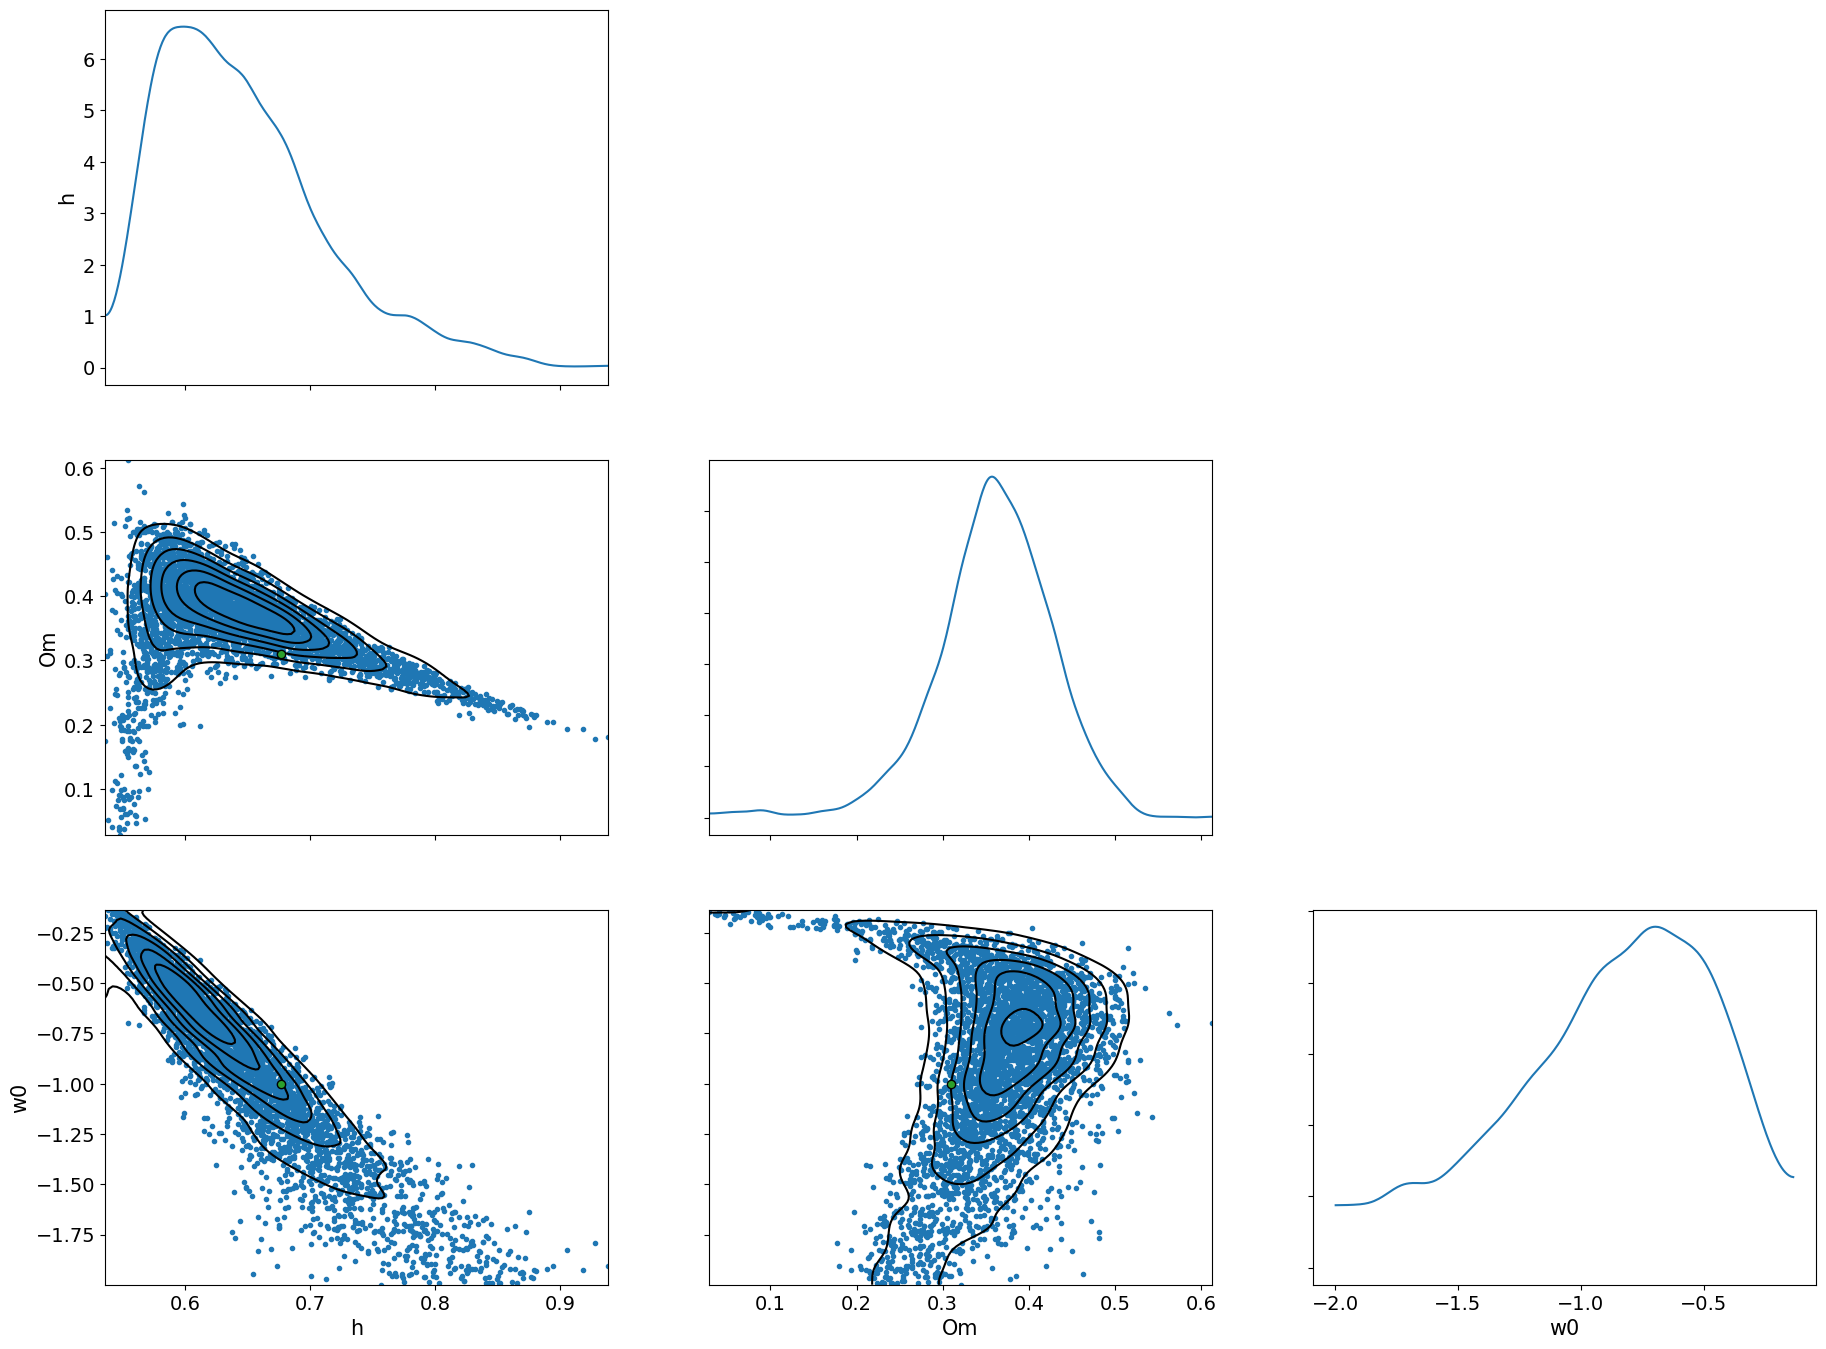

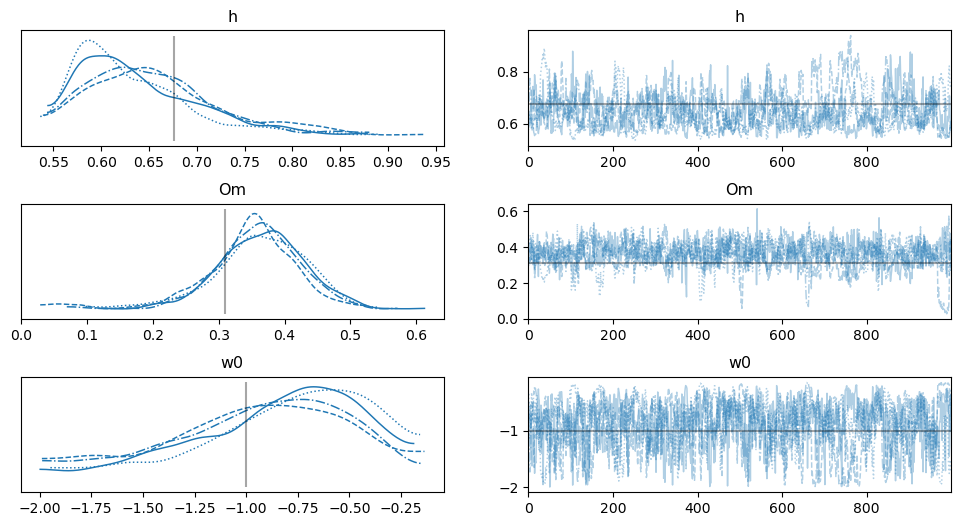

In [11]:
with make_model_w0(zo, do, sigma_z, sigma_DL) as model:
    trace_w0 = pm.sample(tune=2000, target_accept=0.99)
    
    axes = az.plot_pair(trace_w0, var_names=['h', 'Om', 'w0'], marginals=True, kind=['scatter', 'kde'], divergences=True, 
             reference_values={'h': cp.H0/100, 'Om': cp.Om0, 'w0': -1})
    fig = axes.ravel()[0].figure
    fig.savefig('/home/soumendrakishore.roy/cosmo_gw_systematics/Results/in_LCDM_es_w0CDM_corner.png')
    
    axes1 = az.plot_trace(trace_w0, compact=True, var_names=['h', 'Om', 'w0'],
                  lines=[('h', {}, cp.H0/100),
                         ('Om', {}, cp.Om0),
                        ('w0', {}, -1)])
    axes1.ravel()[0].figure.subplots_adjust(hspace=0.5)
    fig1 = axes1.ravel()[0].figure 
    fig1.savefig('/home/soumendrakishore.roy/cosmo_gw_systematics/Results/in_LCDM_es_w0CDM.png')